# Pump it Up: Data Mining the Water Table

In [1]:
# importing all relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

/Users/angelahc/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Loading training and test datasets downloaded from www.drivendata.org

In [2]:
train = pd.read_csv("/Users/angelahc/Documents/IE/Courses/TERM 2/ML II/Training_water.csv")
test = pd.read_csv("/Users/angelahc/Documents/IE/Courses/TERM 2/ML II/Test_water.csv")
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,0,0.0,11/13/12,Tasaf,0,TASAF,33.125828,-5.118154,Mratibu,0,...,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
1,1,0.0,3/5/11,Shipo,1978,SHIPO,34.770717,-9.395642,none,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
2,2,0.0,3/27/11,Lvia,0,LVIA,36.115056,-6.279268,Bombani,0,...,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional
3,3,10.0,6/3/13,Germany Republi,1639,CES,37.147432,-3.187555,Area 7 Namba 5,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
4,4,0.0,3/22/11,Cmsr,0,CMSR,36.164893,-6.099289,Ezeleda,0,...,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional


# 1. Feature Engineering

### 1.1. Understanding the variables:

An initial exploration was also done using Dataiku.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

In [4]:
train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [5]:
str(train.shape)

'(59400, 41)'

In [6]:
str(test.shape)

'(14850, 40)'

In [7]:
print ("Distribution of labels/target variable in training dataset:")
train['status_group'].value_counts()

Distribution of labels/target variable in training dataset:


functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

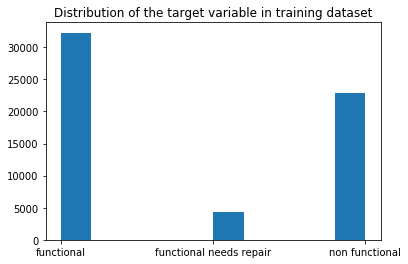

In [8]:
plt.hist(train['status_group'])
plt.title("Distribution of the target variable in training dataset");

From the graph, we see that we are a lot more functional and non-functional wells. Because of this, we may be more accurate at identifying these two wells in the test set.

### 1.2. Examinating null values:

In [9]:
train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [10]:
missing_value = train.columns[train.isnull().any()]
print("There are", str(len(missing_value)), "columns with missing values.")

There are 7 columns with missing values.


Out of the 7 columns with missing values, I ended up just using "funder" and "installer." More on that later.

### 1.3. Eliminating irrelevant and repeated columns:

In [11]:
# checking whether all IDs are unique
train.id.nunique() == train['id'].count()

True

In [12]:
# combining the train and test datasets so changes do not have to be performed twice
df = train.append(test, ignore_index = True)

In [13]:
df = df.drop(["id"], axis = 1)
# dropping column "id" because it would not add value to the model.

In [14]:
df.recorded_by.nunique()

1

In [15]:
df = df.drop(["recorded_by"], axis = 1)
# "recorded_by" has only 1 unique value, which would not add much value to the model.

In [16]:
(df['num_private'].value_counts()/len(df)).head(1)
# most of the values are 0.

0    0.987192
Name: num_private, dtype: float64

In [17]:
df = df.drop(["num_private"], axis = 1)
# no description is provided for "num_private" and most values for this column are 0; so, we drop this column

In [18]:
df = df.drop(["wpt_name", "scheme_management", "scheme_name", 
              "permit", "public_meeting"], axis = 1)
# irrelavant for modelling

In [19]:
df = df.drop(["region", "subvillage", "lga", "extraction_type",
              "extraction_type_class", "management", "payment",
              "quality_group", "quantity", "source_type",
              "source_class", "waterpoint_type_group"], axis = 1)
# droppping columns with repeated information

### 1.4. Analyzing numeric variables and performing transformation:

a. "amount_tsh"

In [20]:
(df.amount_tsh == 0).sum()

52049

Amount_tsh is the amount of water available to waterpoint. For non-functional wells, it may make sense that this variables is 0. However, for functional and non-functional wells, we can interpret that this value does not represent the actual value. Imputation was made; however, this resulted in a worse score. Therefore, I left this column as it is.

b. "date_recorded"

In [21]:
# train and test data had different date recorded forms, so we standardize it here
df["date_recorded"] = df.date_recorded.apply(pd.to_datetime)
df["date_recorded"].head()

0   2012-11-13
1   2011-03-05
2   2011-03-27
3   2013-06-03
4   2011-03-22
Name: date_recorded, dtype: datetime64[ns]

c. "gps_height"

In [22]:
(df.gps_height < 1).sum()

27530

Gps_height means the altitude of the well. For all wells, it would not make sense to have a value less than 1. In the dataset, there are some wells with value 0 and others with negative values. Imputation was made based on the mean according to "ward"/location; however, this resulted in a worse score. Therefore, I left this column as it is.

d. Latitude and Longitude

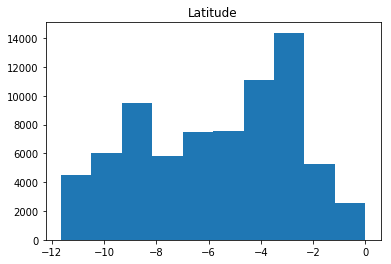

In [23]:
plt.hist(df.latitude)
plt.title("Latitude");

In [24]:
print("There are",(df.latitude == -2e-08).sum(), "values that are not inside of Tanzania.")

There are 2269 values that are not inside of Tanzania.


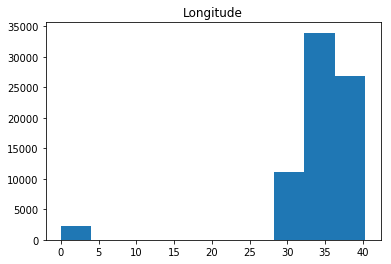

In [25]:
plt.hist(df.longitude)
plt.title("Longitude");

In [26]:
print("There are",(df.longitude == 0).sum(), "values that are not inside of Tanzania.")

There are 2269 values that are not inside of Tanzania.


These coordinates, verified by data visualization in Tableau, indicate that some wells in the dataset are not located in Tanzania, which should not be the case. Therefore, the incorrect values were supposed to be replaced accordingly with the average of coordinates of each district ("district_code").

In [27]:
#long = df[df["longitude"] == 0]
#long.iloc[:,df.columns == "latitude"]= np.nan
#long.iloc[:,df.columns == "longitude"]= np.nan
#df[df["longitude"] == 0] = long
#df["longitude"] = df.groupby("district_code").transform(lambda x: x.fillna(x.mean())).longitude
#df["latitude"] = df.groupby("district_code").transform(lambda x: x.fillna(x.mean())).latitude

/Users/angelahc/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


However, the above imputation worsened my score, so I left this variable untouched.

e. "population"

In [30]:
(df.population == 0).sum()

26834

In [31]:
#df.population = np.log10(df.population+1)

Population is expected to be more than zero. Imputation was made; however, this resulted in a worse score. Therefore, I left the variable as it is.

An incorrect imputation affects more the model than leaving the variables "population", "latitude", "longitude", "gps_height" and "amount_tsh" as they are. As imputation did not help in predicting the type of wells, their values, even though unreasonable, might have an informative correlation. 

f. "construction_year"

In [32]:
(df.construction_year[df.construction_year !=0]).mean()

1996.8709430210642

In [23]:
df.loc[df.construction_year == 0, df.columns=='construction_year'] = 1950
# 0 is clearly an incorrect value
# replacing all 0 with the mean of construction year after taking out some outliners -> 1950

In [24]:
df['operation_time'] = df.date_recorded-df.construction_year.apply(lambda x: pd.to_datetime(x,format='%Y'))
df.operation_time = (df.operation_time/np.timedelta64(1, 'D')).astype(int)
df['operation_time']=df.operation_time/365
(df.loc[df['operation_time'] < 0]).operation_time= df.operation_time.mean()
# variable operation time was created as it is believed to be more meaningful

/Users/angelahc/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [25]:
df = df.drop(['date_recorded'], axis =1)
# date_recorded itself does not convey much information, so we delete it

### 1.5. Creating dummy variables with categorical variables:

In [26]:
df.funder.replace(['0'], [np.nan], inplace=True)
df.installer.replace(['0'], [np.nan], inplace=True)
# both 0 and null values meant null values, so we transform all zeros to be null.

In [27]:
(df["funder"] == '0').sum()
# checking if values are successfully replaced

0

In [28]:
(df["installer"] == '0').sum()
# checking if values are successfully replaced

0

In [29]:
lst= ["funder", "installer", "basin", "ward", "extraction_type_group"
      "management_group", "payment_type", "water_quality",
      "quantity_group", "source", "waterpoint_type"]

In [30]:
df_dummies = pd.get_dummies(df[np.intersect1d(df.columns, lst)])
df_dummies.head()

,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,funder_A/co Germany,...,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0


In [31]:
df = df.drop(["funder", "installer", "basin", "ward", "extraction_type_group",
      "management_group", "payment_type", "water_quality",
      "quantity_group", "source", "waterpoint_type"], axis =1)
# keeping only the dummy variables

### Ready to apply models:

In [32]:
df_vf = pd.concat([df, df_dummies], axis =1)

In [33]:
# separating the datasets after all changes
train_water = df_vf.iloc[:59400,:]
test_water = df_vf.iloc[59400:,:]

In [34]:
del test_water['status_group']

## 2. Modelling

### 2.1. Random Forest

In [35]:
factors = list(df_vf.iloc[:,df_vf.columns != 'status_group'])

In [36]:
y = pd.factorize(train_water['status_group'])[0]

2.1.1. Tunning the parameters of Random Forest Classifier

In [47]:
#param_grid = {
#    'bootstrap': [True, False],
#    'min_samples_leaf': [3, 4, 5],
#    'n_estimators': [50, 100, 200, 300, 500, 1000]
#}

#rf = RandomForestRegressor()

#grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1)

In [48]:
# searching for the best parameters with Grid Search
#grid_search.fit(train_water, y)
#grid_search.best_params_

In [49]:
#print('Best Score: {}'.format(grid_search.best_score_))

2.1.2. Creating model only with highly important features

In [50]:
#importance = list(modelRFC.feature_importances_)
#feature_importance = [(feature, round(importance, 2)) for feature, importance in zip(factors, importance)]
#feature_importance = sorted(feature_importance, key = lambda x: x[1], reverse = True)

In [51]:
#sorted_importance = [importance[1] for importance in feature_importance]
#cumulative_importance = np.cumsum(sorted_importance)
#print('Number of features for 70% importance:', np.where(cumulative_importance > 0.7)[0][0] + 1)

In [52]:
#important_feature = [feature[0] for feature in feature_importance[0:17]]
#important_feature

In [53]:
#X_train, X_test, y_train, y_test = train_test_split(train_water[important_feature], train_water.status_group, test_size=0.1, random_state=10)
#print(X_train.shape, X_test.shape)

In [54]:
#clf = RandomForestClassifier(n_estimators=1000,min_samples_split=10,criterion='entropy',random_state=10)
#clf.fit(X_train,y_train)
#predictions = clf.predict(test_water[important_feature])

In [55]:
#accuracy_score(clf.predict(X_train), y_train)

2.1.3. Running the model

In [56]:
#X_train, X_test, y_train, y_test = train_test_split(train_water[factors], train_water.status_group, test_size=0.1, random_state=10)
#print(X_train.shape, X_test.shape)

In [41]:
clf = RandomForestClassifier(n_estimators=1000, min_samples_split=10, criterion='entropy', random_state=10)
clf.fit(train_water[factors], train_water.status_group)
predictions = clf.predict(test_water[factors])

In [42]:
accuracy_score(clf.predict(train_water[factors]), train_water.status_group)

0.9037205387205387

### 2.2. LDA

I tried modelling with LDA; however, random forest gave me best results. Below I leave the code.

In [59]:
#X = train_water.iloc[:,train_water.columns != 'status_group']

In [60]:
#y = pd.factorize(train_water['status_group'])[0]

In [61]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [62]:
#lda = LDA(n_components = None)
#lda.fit(X_train,y_train)

2.2.1. Finding the best number of components

In [63]:
#lda_var_ratios = lda.explained_variance_ratio_

In [64]:
#def select_n_components(var_ratio, goal_var: float) -> int:
    #total_variance = 0.0
    #n_components = 0
    #for explained_variance in var_ratio:
    #    total_variance += explained_variance
    #    n_components += 1
    #    if total_variance >= goal_var:
    #        break
        
    #return n_components

In [65]:
#select_n_components(lda_var_ratios, 0.95)

2.2.2. Running the model

In [66]:
#lda = LDA(n_components = 2)
#lda.fit(X_train,y_train)
#predictions_lda = lda.predict(test_water[factors])

In [67]:
#confusion_matrix(y_test, y_pred)

## 3. Confusion Matrix

This was used to further check the accuracy in predicting each of the type of well, when cross validation was performed.

Confusion matrix
[[ 0.89906542  0.01339564  0.08753894]
 [ 0.51724138  0.30114943  0.1816092 ]
 [ 0.20610022  0.01220044  0.78169935]]


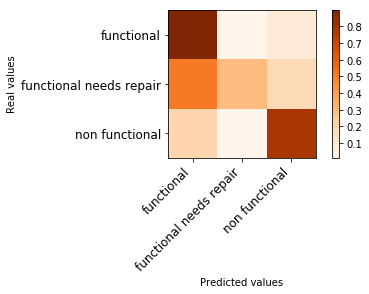

Test Score: 0.809932659933


In [235]:
labels=['functional','functional needs repair','non functional']

def conf_matrix(cm, cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(shrink=1)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=12)
    plt.yticks(tick_marks, labels , fontsize=12)
    plt.tight_layout()
    plt.ylabel('Real values')
    plt.xlabel('Predicted values')

# creating confusion matrix
cm = confusion_matrix(y_test, modelRFC.predict(X_test))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion matrix')
print(cm_normalized)
plt.figure()
conf_matrix(cm_normalized)
plt.show()

# show test score
print('Test Score:', cm.diagonal().sum()/float(cm.sum()))

## 4. Submission

In [44]:
submission = pd.DataFrame(predictions, columns=['status_group'])
test = pd.read_csv("test_water.csv")
submission.insert(0, 'id', test['id'])
submission.reset_index()
submission.to_csv('submission_final.csv', index = False)

Score in "Pump it Up: Data Mining the Water Table": 0.8172